<span style="color:blue"> Бизнес-задача: 
- Предложить стратегию инвестиций в разработку игр, выявив связь между характеристиками игр (жанр, средний рейтинг, платформа) и их коммерческим успехом (продажи, выручка). </span>

In [307]:
# Импортируем необходимые для работы библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [308]:
games_rate_data = pd.read_csv('games.csv')
games_revenue_data = pd.read_csv('gamalytic_games.csv')

games_rate_data['esrb_rating'] = games_rate_data['esrb_rating'].fillna('No age rating')
games_rate_data = games_rate_data.rename(columns={'esrb_rating': 'age_rating'})

games_revenue = games_revenue_data.drop(columns=['steamId', 'unreleased', 'earlyAccess', 'publishers', 'headerUrl', 'steamUrl'])

`Заметим, что есть строки в двух датасетах, где игры одинаковые, но названия имею различия, поэтому необходимо грамотно обработать такие случаи, чтобы впоследствии соединить датасеты`

In [309]:
import re

def clean(column):
    column = str(column).lower()
    column = re.sub(r'[^a-z0-9]', ' ', column)
    column = re.sub(r'\s+', ' ', column).strip()
    return column

def numeric_part(n):
    return ' '.join(re.findall(r'\d+', str(n)))

gd = games_rate_data.copy()
gr = games_revenue.copy()

gd['filter_name'] = gd['name'].apply(clean)
gr['filter_name'] = gr['name'].apply(clean)

gd = gd[gd['filter_name'] != '']
gr = gr[gr['filter_name'] != '']

gd['num_value'] = gd['filter_name'].apply(numeric_part)
gr['num_value'] = gr['filter_name'].apply(numeric_part)

joined = pd.merge(gr, gd, on=['filter_name', 'num_value'], how='inner', suffixes=('_rev', '_data'))

joined


,name_rev,firstReleaseDate,copiesSold,price,revenue,reviewScore,publisherClass,developers,filter_name,num_value,name_data,released,rating,age_rating,genres,platforms
0,Counter-Strike 2,2012-05-01T00:00:00.000Z,324828766,0.00,9898329661,86,AAA,Valve,counter strike 2,2,Counter-Strike 2,2023-09-27,3.58,Mature,Shooter,"Linux, PC"
1,Dota 2,2011-08-01T00:00:00.000Z,213939465,0.00,2091450944,81,AAA,Valve,dota 2,2,Dota 2,2013-07-09,3.07,No age rating,"Action, Massively Multiplayer","Linux, macOS, PC"
2,Apex Legends™,2020-11-04T05:00:00.000Z,72503084,0.00,1491767840,67,AAA,Respawn,apex legends,,Apex Legends,2019-02-04,3.64,Teen,"Action, Shooter","PlayStation 4, Nintendo Switch, macOS, PC, Xbo..."
3,Destiny 2,2019-10-01T04:00:00.000Z,38861886,0.00,901439163,78,AAA,Bungie,destiny 2,2,Destiny 2,2017-09-06,3.52,Teen,"Action, Shooter","PlayStation 4, Xbox One, PC, Web, Xbox Series ..."
4,Warframe,2013-03-25T04:00:00.000Z,47103348,0.00,879275446,87,AAA,Digital Extremes,warframe,,Warframe,2013-03-25,3.42,No age rating,"Action, Shooter, RPG, Massively Multiplayer","iOS, Xbox Series S/X, PlayStation 5, PlayStati..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5711,Mirror Maker,2019-01-17T05:00:00.000Z,83137,1.99,65436,71,Indie,KAGAMI WORKs,mirror maker,,Mirror Maker,2019-01-24,1.75,No age rating,"RPG, Simulation, Indie",PC
5712,Kromaia,2014-10-23T04:00:00.000Z,10378,9.99,65277,75,Indie,Kraken Empire,kromaia,,Kromaia,2014-10-22,0.00,No age rating,"Action, Shooter, Arcade, Indie","PlayStation 4, PC"
5713,DUCATI - 90th Anniversary,2016-06-09T04:00:00.000Z,11258,9.99,65188,74,AA,Milestone S.r.l.,ducati 90th anniversary,90,DUCATI - 90th Anniversary,2016-06-09,2.60,No age rating,"Simulation, Sports, Racing","PlayStation 4, PC, Xbox One"
5714,The Chaos Engine,2013-08-29T04:00:00.000Z,26117,9.99,65092,68,AA,"Abstraction Games,The Bitmap Brothers",the chaos engine,,The Chaos Engine,1993-03-01,3.67,No age rating,"Action, Shooter","Atari ST, Classic Macintosh, SNES, Commodore /..."


In [310]:
joined = joined.drop(columns=['num_value', 'name_rev', 'filter_name']) # Удаляем лишние (дублирующие) столбцы для дальнейшей работы с данными
cols = list(joined.columns)

cols


['firstReleaseDate',
 'copiesSold',
 'price',
 'revenue',
 'reviewScore',
 'publisherClass',
 'developers',
 'name_data',
 'released',
 'rating',
 'age_rating',
 'genres',
 'platforms']

In [311]:
cols[0], cols[7] = cols[7], cols[0] # Восстанавливаем исходный порядок колонок
joined = joined[cols]

joined = joined.rename(columns={'name_data': 'name'}) # Возвращаем исходное название колонки

joined

,name,copiesSold,price,revenue,reviewScore,publisherClass,developers,firstReleaseDate,released,rating,age_rating,genres,platforms
0,Counter-Strike 2,324828766,0.00,9898329661,86,AAA,Valve,2012-05-01T00:00:00.000Z,2023-09-27,3.58,Mature,Shooter,"Linux, PC"
1,Dota 2,213939465,0.00,2091450944,81,AAA,Valve,2011-08-01T00:00:00.000Z,2013-07-09,3.07,No age rating,"Action, Massively Multiplayer","Linux, macOS, PC"
2,Apex Legends,72503084,0.00,1491767840,67,AAA,Respawn,2020-11-04T05:00:00.000Z,2019-02-04,3.64,Teen,"Action, Shooter","PlayStation 4, Nintendo Switch, macOS, PC, Xbo..."
3,Destiny 2,38861886,0.00,901439163,78,AAA,Bungie,2019-10-01T04:00:00.000Z,2017-09-06,3.52,Teen,"Action, Shooter","PlayStation 4, Xbox One, PC, Web, Xbox Series ..."
4,Warframe,47103348,0.00,879275446,87,AAA,Digital Extremes,2013-03-25T04:00:00.000Z,2013-03-25,3.42,No age rating,"Action, Shooter, RPG, Massively Multiplayer","iOS, Xbox Series S/X, PlayStation 5, PlayStati..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5711,Mirror Maker,83137,1.99,65436,71,Indie,KAGAMI WORKs,2019-01-17T05:00:00.000Z,2019-01-24,1.75,No age rating,"RPG, Simulation, Indie",PC
5712,Kromaia,10378,9.99,65277,75,Indie,Kraken Empire,2014-10-23T04:00:00.000Z,2014-10-22,0.00,No age rating,"Action, Shooter, Arcade, Indie","PlayStation 4, PC"
5713,DUCATI - 90th Anniversary,11258,9.99,65188,74,AA,Milestone S.r.l.,2016-06-09T04:00:00.000Z,2016-06-09,2.60,No age rating,"Simulation, Sports, Racing","PlayStation 4, PC, Xbox One"
5714,The Chaos Engine,26117,9.99,65092,68,AA,"Abstraction Games,The Bitmap Brothers",2013-08-29T04:00:00.000Z,1993-03-01,3.67,No age rating,"Action, Shooter","Atari ST, Classic Macintosh, SNES, Commodore /..."


In [312]:
cleaned = joined[joined['rating'] != 0] # Удаляем строки, где рейтинг равен 0, так как они не имеют ценности для анализа зависимости от выручки с игры
cleaned = cleaned.reset_index()
cleaned = cleaned.drop(columns=['index'])

cleaned

,name,copiesSold,price,revenue,reviewScore,publisherClass,developers,firstReleaseDate,released,rating,age_rating,genres,platforms
0,Counter-Strike 2,324828766,0.00,9898329661,86,AAA,Valve,2012-05-01T00:00:00.000Z,2023-09-27,3.58,Mature,Shooter,"Linux, PC"
1,Dota 2,213939465,0.00,2091450944,81,AAA,Valve,2011-08-01T00:00:00.000Z,2013-07-09,3.07,No age rating,"Action, Massively Multiplayer","Linux, macOS, PC"
2,Apex Legends,72503084,0.00,1491767840,67,AAA,Respawn,2020-11-04T05:00:00.000Z,2019-02-04,3.64,Teen,"Action, Shooter","PlayStation 4, Nintendo Switch, macOS, PC, Xbo..."
3,Destiny 2,38861886,0.00,901439163,78,AAA,Bungie,2019-10-01T04:00:00.000Z,2017-09-06,3.52,Teen,"Action, Shooter","PlayStation 4, Xbox One, PC, Web, Xbox Series ..."
4,Warframe,47103348,0.00,879275446,87,AAA,Digital Extremes,2013-03-25T04:00:00.000Z,2013-03-25,3.42,No age rating,"Action, Shooter, RPG, Massively Multiplayer","iOS, Xbox Series S/X, PlayStation 5, PlayStati..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5453,American Conquest,30326,4.99,65545,68,Indie,GSC Game World,2011-08-27T04:00:00.000Z,2002-11-15,3.68,No age rating,Strategy,PC
5454,Mirror Maker,83137,1.99,65436,71,Indie,KAGAMI WORKs,2019-01-17T05:00:00.000Z,2019-01-24,1.75,No age rating,"RPG, Simulation, Indie",PC
5455,DUCATI - 90th Anniversary,11258,9.99,65188,74,AA,Milestone S.r.l.,2016-06-09T04:00:00.000Z,2016-06-09,2.60,No age rating,"Simulation, Sports, Racing","PlayStation 4, PC, Xbox One"
5456,The Chaos Engine,26117,9.99,65092,68,AA,"Abstraction Games,The Bitmap Brothers",2013-08-29T04:00:00.000Z,1993-03-01,3.67,No age rating,"Action, Shooter","Atari ST, Classic Macintosh, SNES, Commodore /..."


In [313]:
one_hotted_platforms = cleaned['platforms'].str.get_dummies(sep=', ') # Применяем one-hot encoding для сепарирования платформ и анализа конкретно интересующих (популярных)
one_hotted_platforms.columns

Index(['3DO', 'Android', 'Apple II', 'Atari ST', 'Classic Macintosh',
       'Commodore / Amiga', 'Dreamcast', 'Game Boy', 'Game Boy Advance',
       'Game Boy Color', 'Game Gear', 'GameCube', 'Genesis', 'Jaguar', 'Linux',
       'NES', 'Neo Geo', 'Nintendo 3DS', 'Nintendo 64', 'Nintendo DS',
       'Nintendo DSi', 'Nintendo Switch', 'PC', 'PS Vita', 'PSP',
       'PlayStation', 'PlayStation 2', 'PlayStation 3', 'PlayStation 4',
       'PlayStation 5', 'SEGA 32X', 'SEGA CD', 'SEGA Master System',
       'SEGA Saturn', 'SNES', 'Web', 'Wii', 'Wii U', 'Xbox', 'Xbox 360',
       'Xbox One', 'Xbox Series S/X', 'iOS', 'macOS'],
      dtype='object')

In [314]:
one_hotted_genres = cleaned['genres'].str.get_dummies(sep=', ') # Применяем one-hot encoding для сепарирования жанров
one_hotted_genres.columns

Index(['Action', 'Adventure', 'Arcade', 'Board Games', 'Card', 'Casual',
       'Educational', 'Family', 'Fighting', 'Indie', 'Massively Multiplayer',
       'Platformer', 'Puzzle', 'RPG', 'Racing', 'Shooter', 'Simulation',
       'Sports', 'Strategy'],
      dtype='object')

In [315]:
cleaned = pd.concat([cleaned, one_hotted_genres, one_hotted_platforms], axis=1)
cleaned

,name,copiesSold,price,revenue,reviewScore,publisherClass,developers,firstReleaseDate,released,rating,...,SNES,Web,Wii,Wii U,Xbox,Xbox 360,Xbox One,Xbox Series S/X,iOS,macOS
0,Counter-Strike 2,324828766,0.00,9898329661,86,AAA,Valve,2012-05-01T00:00:00.000Z,2023-09-27,3.58,...,0,0,0,0,0,0,0,0,0,0
1,Dota 2,213939465,0.00,2091450944,81,AAA,Valve,2011-08-01T00:00:00.000Z,2013-07-09,3.07,...,0,0,0,0,0,0,0,0,0,1
2,Apex Legends,72503084,0.00,1491767840,67,AAA,Respawn,2020-11-04T05:00:00.000Z,2019-02-04,3.64,...,0,0,0,0,0,0,1,0,0,1
3,Destiny 2,38861886,0.00,901439163,78,AAA,Bungie,2019-10-01T04:00:00.000Z,2017-09-06,3.52,...,0,1,0,0,0,0,1,1,0,0
4,Warframe,47103348,0.00,879275446,87,AAA,Digital Extremes,2013-03-25T04:00:00.000Z,2013-03-25,3.42,...,0,0,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5453,American Conquest,30326,4.99,65545,68,Indie,GSC Game World,2011-08-27T04:00:00.000Z,2002-11-15,3.68,...,0,0,0,0,0,0,0,0,0,0
5454,Mirror Maker,83137,1.99,65436,71,Indie,KAGAMI WORKs,2019-01-17T05:00:00.000Z,2019-01-24,1.75,...,0,0,0,0,0,0,0,0,0,0
5455,DUCATI - 90th Anniversary,11258,9.99,65188,74,AA,Milestone S.r.l.,2016-06-09T04:00:00.000Z,2016-06-09,2.60,...,0,0,0,0,0,0,1,0,0,0
5456,The Chaos Engine,26117,9.99,65092,68,AA,"Abstraction Games,The Bitmap Brothers",2013-08-29T04:00:00.000Z,1993-03-01,3.67,...,1,0,0,0,0,0,0,0,0,1


In [316]:
cleaned['platforms_count'] = cleaned.loc[:, 'PC':'Xbox Series S/X'].sum(axis=1)
cleaned

,name,copiesSold,price,revenue,reviewScore,publisherClass,developers,firstReleaseDate,released,rating,...,Web,Wii,Wii U,Xbox,Xbox 360,Xbox One,Xbox Series S/X,iOS,macOS,platforms_count
0,Counter-Strike 2,324828766,0.00,9898329661,86,AAA,Valve,2012-05-01T00:00:00.000Z,2023-09-27,3.58,...,0,0,0,0,0,0,0,0,0,1
1,Dota 2,213939465,0.00,2091450944,81,AAA,Valve,2011-08-01T00:00:00.000Z,2013-07-09,3.07,...,0,0,0,0,0,0,0,0,1,1
2,Apex Legends,72503084,0.00,1491767840,67,AAA,Respawn,2020-11-04T05:00:00.000Z,2019-02-04,3.64,...,0,0,0,0,0,1,0,0,1,3
3,Destiny 2,38861886,0.00,901439163,78,AAA,Bungie,2019-10-01T04:00:00.000Z,2017-09-06,3.52,...,1,0,0,0,0,1,1,0,0,6
4,Warframe,47103348,0.00,879275446,87,AAA,Digital Extremes,2013-03-25T04:00:00.000Z,2013-03-25,3.42,...,0,0,0,0,0,1,1,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5453,American Conquest,30326,4.99,65545,68,Indie,GSC Game World,2011-08-27T04:00:00.000Z,2002-11-15,3.68,...,0,0,0,0,0,0,0,0,0,1
5454,Mirror Maker,83137,1.99,65436,71,Indie,KAGAMI WORKs,2019-01-17T05:00:00.000Z,2019-01-24,1.75,...,0,0,0,0,0,0,0,0,0,1
5455,DUCATI - 90th Anniversary,11258,9.99,65188,74,AA,Milestone S.r.l.,2016-06-09T04:00:00.000Z,2016-06-09,2.60,...,0,0,0,0,0,1,0,0,0,3
5456,The Chaos Engine,26117,9.99,65092,68,AA,"Abstraction Games,The Bitmap Brothers",2013-08-29T04:00:00.000Z,1993-03-01,3.67,...,0,0,0,0,0,0,0,0,1,2


In [317]:
main_columns = ['name', 'copiesSold', 'price', 'revenue', 'publisherClass', 'developers', 'firstReleaseDate', 'rating', 'age_rating', 'platforms_count']
genres = ['Action', 'Adventure', 'Arcade', 'Board Games', 'Card', 'Casual', 'Educational', 'Family', 'Fighting', 'Indie', 'Massively Multiplayer', 'Platformer', 'Puzzle', 'RPG', 'Racing', 'Shooter', 'Simulation', 'Sports', 'Strategy']
prefers_platforms = ['PC', 'Android', 'iOS', 'macOS', 'Nintendo Switch', 'PlayStation 4', 'PlayStation 5', 'Xbox One', 'Xbox Series S/X'] # Берем только игры, выпущенные на самых популярных платформах

main_df = cleaned[main_columns + genres + prefers_platforms].copy() # Выделяем необходимые нам признаки

main_df['firstReleaseDate'] = pd.to_datetime(main_df['firstReleaseDate']).dt.date # Изменяем тип признака в формат времени

main_df # Далее работаем с этим очищенным датасетом

,name,copiesSold,price,revenue,publisherClass,developers,firstReleaseDate,rating,age_rating,platforms_count,...,Strategy,PC,Android,iOS,macOS,Nintendo Switch,PlayStation 4,PlayStation 5,Xbox One,Xbox Series S/X
0,Counter-Strike 2,324828766,0.00,9898329661,AAA,Valve,2012-05-01,3.58,Mature,1,...,0,1,0,0,0,0,0,0,0,0
1,Dota 2,213939465,0.00,2091450944,AAA,Valve,2011-08-01,3.07,No age rating,1,...,0,1,0,0,1,0,0,0,0,0
2,Apex Legends,72503084,0.00,1491767840,AAA,Respawn,2020-11-04,3.64,Teen,3,...,0,1,0,0,1,1,1,0,1,0
3,Destiny 2,38861886,0.00,901439163,AAA,Bungie,2019-10-01,3.52,Teen,6,...,0,1,0,0,0,0,1,1,1,1
4,Warframe,47103348,0.00,879275446,AAA,Digital Extremes,2013-03-25,3.42,No age rating,5,...,0,1,0,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5453,American Conquest,30326,4.99,65545,Indie,GSC Game World,2011-08-27,3.68,No age rating,1,...,1,1,0,0,0,0,0,0,0,0
5454,Mirror Maker,83137,1.99,65436,Indie,KAGAMI WORKs,2019-01-17,1.75,No age rating,1,...,0,1,0,0,0,0,0,0,0,0
5455,DUCATI - 90th Anniversary,11258,9.99,65188,AA,Milestone S.r.l.,2016-06-09,2.60,No age rating,3,...,0,1,0,0,0,0,1,0,1,0
5456,The Chaos Engine,26117,9.99,65092,AA,"Abstraction Games,The Bitmap Brothers",2013-08-29,3.67,No age rating,2,...,0,1,0,0,1,0,0,0,0,0


In [318]:
classes = main_df['publisherClass'].unique()
classes

array(['AAA', 'AA', 'Hobbyist', 'Indie'], dtype=object)

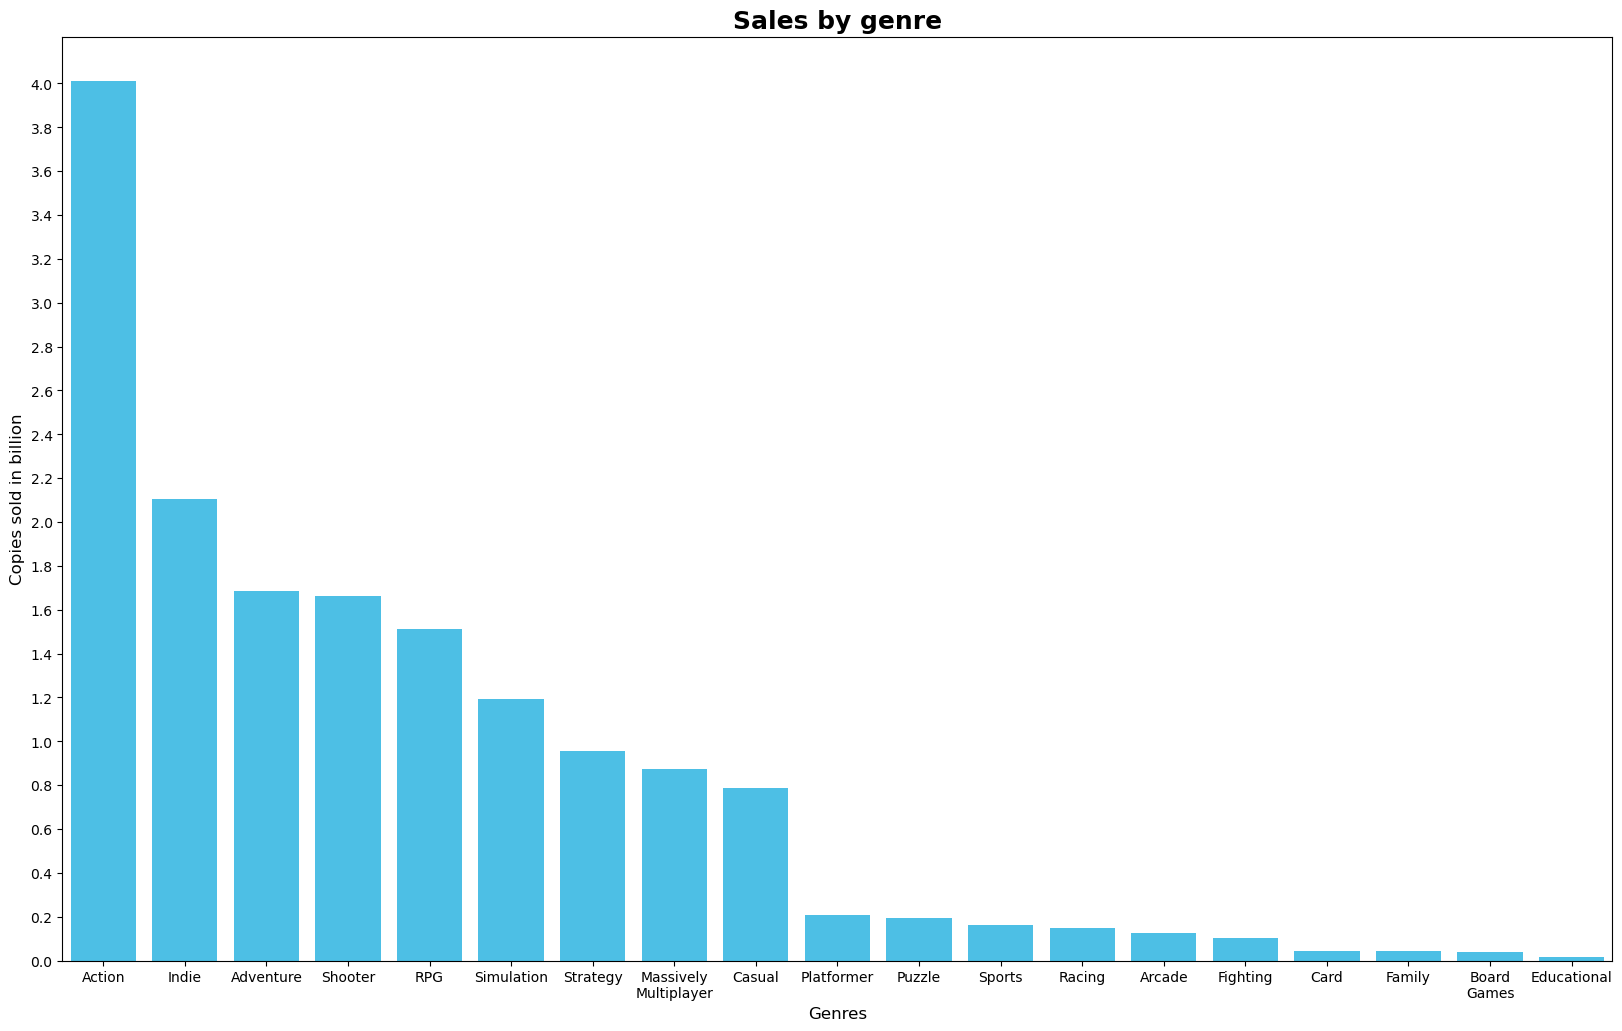

In [319]:
# Визуализируем продажи игр по их жанрам
data = []
for genre in genres:
    copiesSold = main_df[main_df[genre] == 1]['copiesSold'].sum()
    data.append({'Genre': genre, 'copiesSold': copiesSold})

genres_with_the_highest_sales = pd.DataFrame(data)
genres_with_the_highest_sales['copiesSold'] = genres_with_the_highest_sales['copiesSold'] / 1000000000
genres_with_the_highest_sales = genres_with_the_highest_sales.sort_values(by='copiesSold', ascending=False)
genres_with_the_highest_sales['Genre'] = genres_with_the_highest_sales['Genre'].str.replace(' ', '\n') # Чтобы подписи на графике выглядели ровно

plt.figure(figsize=(20, 12))
sns.barplot(data=genres_with_the_highest_sales, x='Genre', y='copiesSold', color='#00BFFF', alpha=0.8)
plt.title('Sales by genre', fontsize=18, fontweight='bold')
plt.xlabel('Genres', fontsize=12)
plt.ylabel('Copies sold in billion', fontsize=12)
plt.yticks(np.arange(0, 4.1, 0.2))
plt.show()

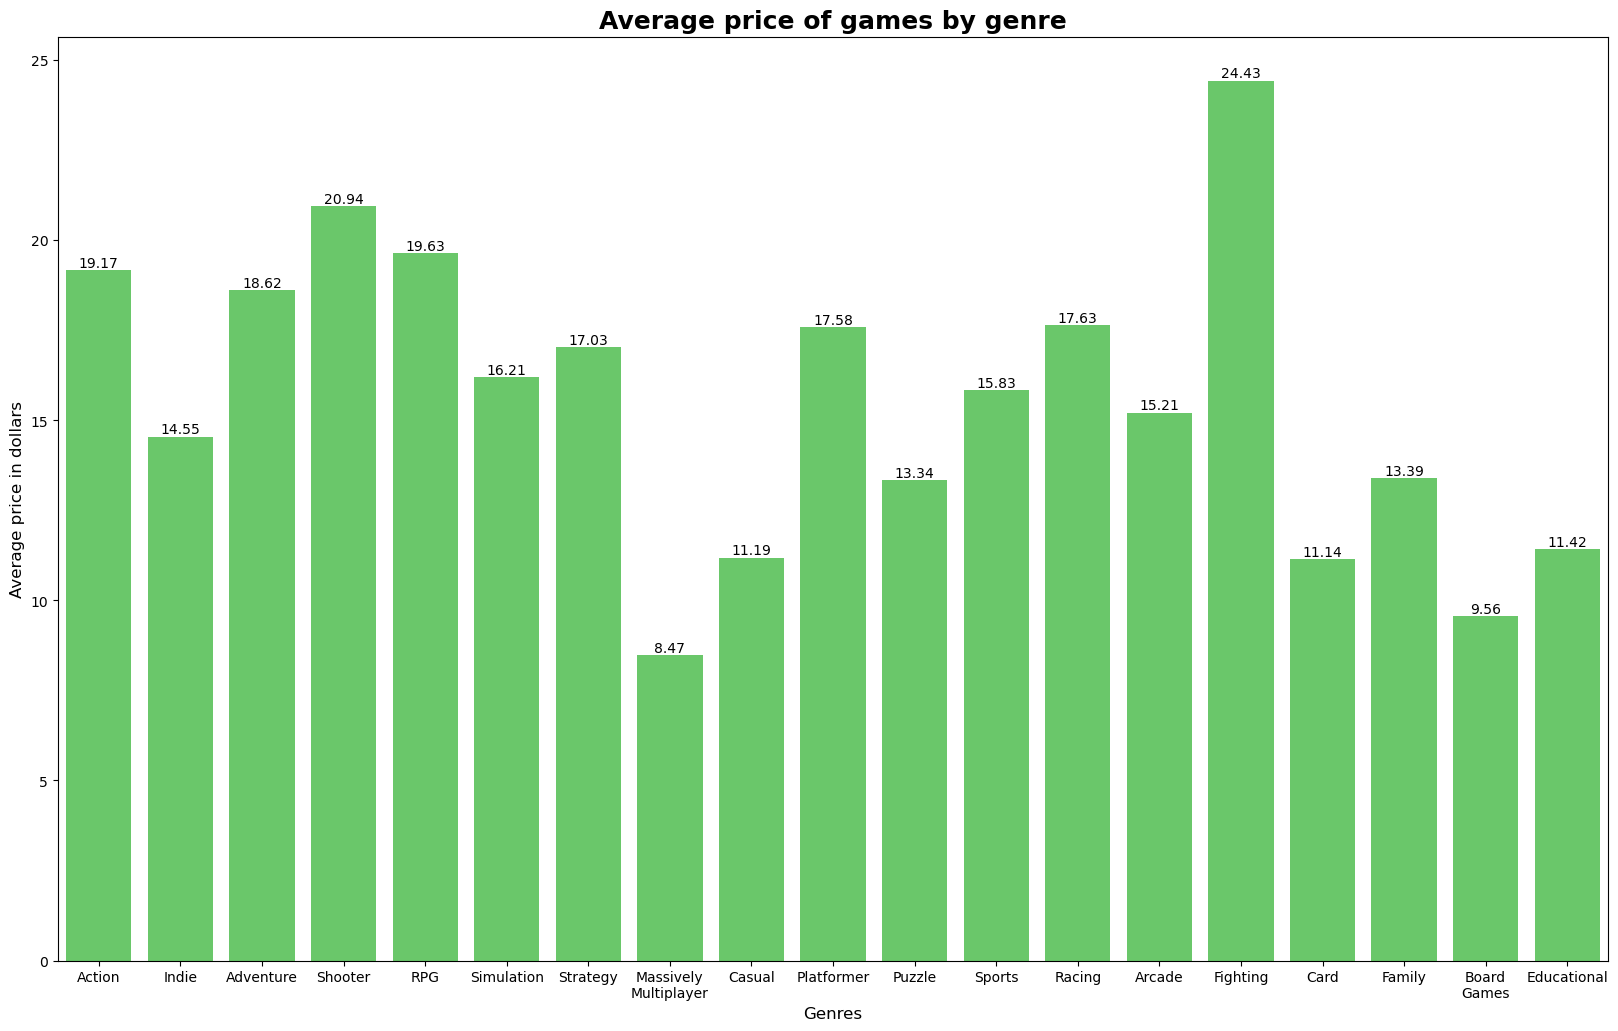

In [320]:
# Анализ цен на игры в зависимости от их жанра
data = []
for genre in genres:
    average_price = main_df[main_df[genre] == 1]['price'].mean()
    data.append({'Genre' : genre, 'average_price' : average_price})

genres_with_average_price = pd.DataFrame(data)
genres_with_average_price = genres_with_average_price.sort_values(by='average_price',ascending=False)
genres_with_average_price['Genre'] = genres_with_average_price['Genre'].str.replace(' ', '\n')

order = genres_with_the_highest_sales['Genre'].tolist()
plt.figure(figsize=(20, 12))
ax = sns.barplot(data=genres_with_average_price, x='Genre', y='average_price', color='limegreen', alpha=0.8, order=order)
for bar in ax.patches:
    plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height(), round(bar.get_height(), 2), ha='center', va='bottom')
plt.title('Average price of games by genre', fontsize=18, fontweight='bold')
plt.xlabel('Genres', fontsize=12)
plt.ylabel('Average price in dollars', fontsize=12)

plt.show()

In [321]:
# Смотрим на то, сколько игр выпущено компаниями разного типа 'publisherClass' и сколько в среднем копий игры продается у компании каждого типа (нижний график)
summary = main_df.groupby('publisherClass')['copiesSold'].agg(['count', 'mean']).reset_index()

fig = make_subplots(rows=2, cols=1, subplot_titles=('<b>Total game count</b>', '<b>Average number of copies sold (millions)</b>'))

fig.add_trace(go.Bar(x=summary['publisherClass'], y=summary['count'], name='Count'), row=1, col=1)
fig.add_trace(go.Bar(x=summary['publisherClass'], y=summary['mean'], name='Copies Sold'), row=2, col=1)

fig.show()

In [324]:
all_classes = main_df['publisherClass'].unique() # Смотрим, какие классы компаний есть

# Проанализируем отдельно для каждого класса прибыльность игр каждого жанра
a_class = main_df[(main_df['publisherClass'] == 'AA') | (main_df['publisherClass'] == 'AAA')].reset_index()
a_class = a_class.drop(columns='index')
hob_class = main_df[main_df['publisherClass'] == 'Hobbyist'].reset_index()
hob_class = hob_class.drop(columns='index')
indie_class = main_df[main_df['publisherClass'] == 'Indie'].reset_index()
indie_class = indie_class.drop(columns='index')

def avg_rev_by_genre(df, genres):
    df = df.copy()
    data = []
    for g in genres:
        games_genre = df[df[g] == 1]
        average_rev = games_genre['revenue'].mean()
        data.append({'Genre': g, 'AverageRevenue': average_rev})
    res = pd.DataFrame(data).sort_values('AverageRevenue', ascending=False)
    return res.reset_index().drop(columns='index')

rev_by_genres_aclass = avg_rev_by_genre(a_class, genres)
rev_by_genres_indie = avg_rev_by_genre(indie_class, genres)
rev_by_genres_hob = avg_rev_by_genre(hob_class, genres)
rev_by_genres_aclass['Genre'] = rev_by_genres_aclass['Genre'].str.replace(' ', '\n')
rev_by_genres_indie['Genre'] = rev_by_genres_indie['Genre'].str.replace(' ', '\n')
rev_by_genres_hob['Genre'] = rev_by_genres_hob['Genre'].str.replace(' ', '\n')

rev_by_genres_hob = rev_by_genres_hob.dropna() # Игр некоторых жанров нет в 'publisherClass' = 'Hobbyist' (получается NaN по средней выручке), просто удаляем эти строки

# Построение барчартов
fig = make_subplots(rows=3, cols=1, vertical_spacing=0.3, row_heights=[0.4, 0.4, 0.4], subplot_titles=['<b>Average revenue by genre in A class types</b>', '<b>Average revenue by genre in Indie class type</b>', '<b>Average revenue by genre in Hobbyist class type</b>'])

fig.add_trace(go.Bar(x=rev_by_genres_aclass['Genre'], y=rev_by_genres_aclass['AverageRevenue'], name='Average revenue (millions)'), row=1, col=1)
fig.add_trace(go.Bar(x=rev_by_genres_indie['Genre'], y=rev_by_genres_indie['AverageRevenue'], name='Average revenue (millions)'), row=2, col=1)
fig.add_trace(go.Bar(x=rev_by_genres_hob['Genre'], y=rev_by_genres_hob['AverageRevenue'], name='Average revenue (millions)'), row=3, col=1)

fig.update_layout(bargap=0.3, height=500)
fig.show()

`График показывает, что самыми прибыльными жанрами для крупных издателей (AA/AAA) являются Massively Multiplayer, Shooter и RPG, в то время как у Indie и Hobbyist наибольшую прибыль приносят более простые жанры — Platformer, Action и Card`

In [323]:
import plotly.graph_objects as go

data = []
for platform in prefers_platforms:
    filter = main_df[main_df[platform] == 1]
    total_sales = filter['copiesSold'].sum()
    avg_rev = filter['revenue'].mean()
    games_number = len(filter)
    data.append([platform, total_sales, avg_rev, games_number])

data = pd.DataFrame(data, columns=['platform', 'sales', 'avg_rev', 'games_number'])
data['size'] =  (data['avg_rev'] - data['avg_rev'].min()) / (data['avg_rev'].max() - data['avg_rev'].min()) # Делаем нормировку средней прибыли игр

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=data['platform'],
    y=data['sales'] ,
    mode='markers',
    marker=dict(
        size=data['size'] * 80 + 20,
        color=data['avg_rev'],
        colorscale='Viridis',
        colorbar=dict(title='<b>The average profit of the game<b>'),
    ),
))

fig.update_layout(title='<b>Sales and average profit of games by platform<b>', xaxis_title='<b>Platforms<b>', yaxis_title='<b>Number of game sales<b>') 
fig.show()

`График показывает, что самыми перспективными платформами являются консоли - PS5 и Xbox Series S/X, так как на данных платформах относительно малое количество конкурентов и наивысшая средняя прибыль на игру`